In [1]:
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *


# Finite element discretisations of the linear shallow water equations
Recall that the linear shallow water equations are prognostic equations for two variables, the velocity $u$ and the fluid depth $h$:
\begin{eqnarray}
u_t + h_x &=& 0, \\
h_t + u_x &=& 0,
\end{eqnarray}
where we have taken the physical parameters describing the acceleration due to gravity $g=1$ and the mean fluid depth $H=1$ and we are considering the non-rotating case.

We will solve these equations on a periodic interval of length 2, using the finite element weak form given by:
\begin{eqnarray}
\int_0^2 (w u_t - w_x h)\, dx &=& 0 \quad &\forall w &\in V_u, \\
\int_0^2 (\phi h_t - \phi_x u) \, dx &=& 0 \quad &\forall \phi &\in V_h.
\end{eqnarray}

Initially we will take both $V_u$ and $V_h$ to be the same: piecewise linear functions, continuous between elements. We will make a mixed finite element space $W = (V_u, V_h)$ and a function $U = (u, h)$ on $W$. Splitting $U$ gives us $u$ and $h$ and we can initialise $h$ as a narrow Gaussian in the middle of the domain. This initial condition should generate two waves, one propagating to the left and one to the right.


/Users/JS1075/firedrake_dec24/src/firedrake/firedrake/function.py:330: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


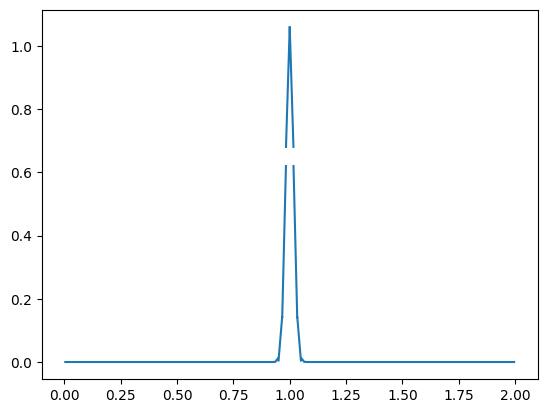

In [2]:
mesh = PeriodicIntervalMesh(120, 2)
Vu = FunctionSpace(mesh, "CG", 2)
Vh = FunctionSpace(mesh, "DG", 1)
W = Vu*Vh
U = Function(W)
u, h = U.split()
x = SpatialCoordinate(mesh)
a = 0.025
h.interpolate(exp(-(x[0]-1)**2/a**2))
plot(h)

Now we set up our finite element weak forms. We will use the implicit midpoint rule as our timestepper and choose a small timestep to be certain that any numerical noise that we see is not the result of violating a stability condition.

Unlike the previous Helmholtz equation example, we will be solving our system many times. It is more computationally efficient to create a Firedrake solver object and reuse it by updating the values in the right hand side at each timestep. In the code below, $U1$ is the function holding the solution values. In the next cell we perform one solve and see how the solution looks...

/Users/JS1075/firedrake_dec24/src/firedrake/firedrake/function.py:330: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


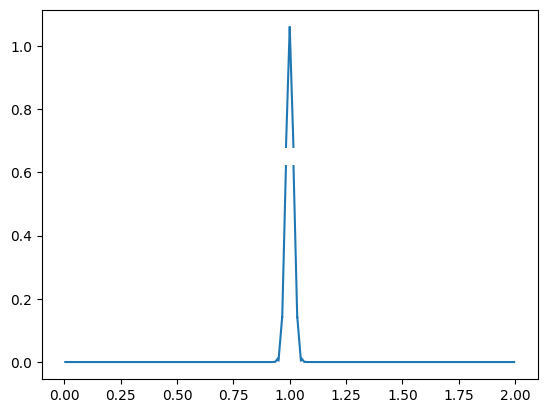

In [3]:
w, phi = TestFunctions(W)
u_, h_ = TrialFunctions(W)
dt = 0.0001

a = inner(w, u_)*dx - 0.5*dt*w.dx(0)*h_*dx + inner(phi, h_)*dx + 0.5*dt*phi*u_.dx(0)*dx
L = inner(w, u)* dx + 0.5*dt*w.dx(0)*h*dx + phi*h*dx - 0.5*dt*phi*u.dx(0)*dx

U1 = Function(W)
prob = LinearVariationalProblem(a, L, U1)
solver = LinearVariationalSolver(prob)
solver.solve()

u1, h1 = U1.split()
plot(h1)

Now we run for a further 1000 timesteps, plotting the fluid height every 100 timesteps. Recall that we expect to see two distinct waves propagating outwards, one in each direction.

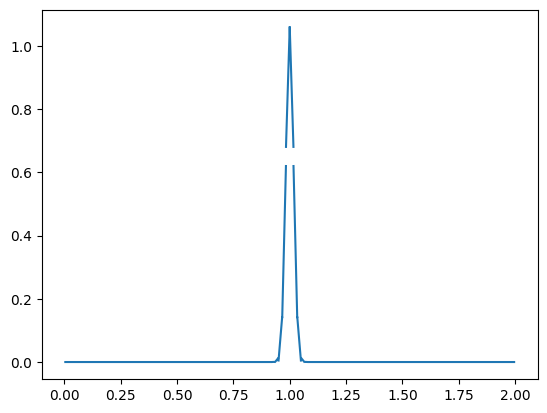

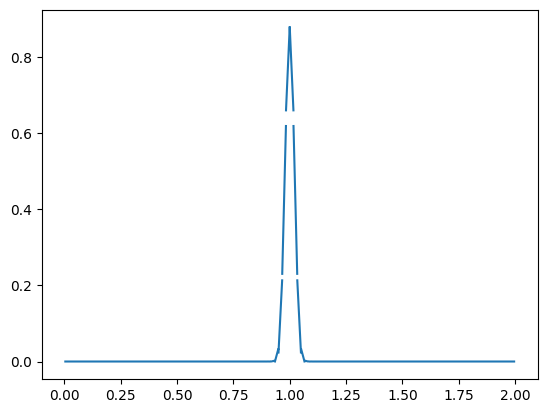

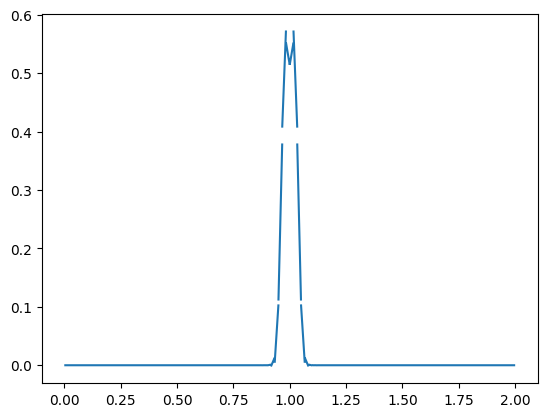

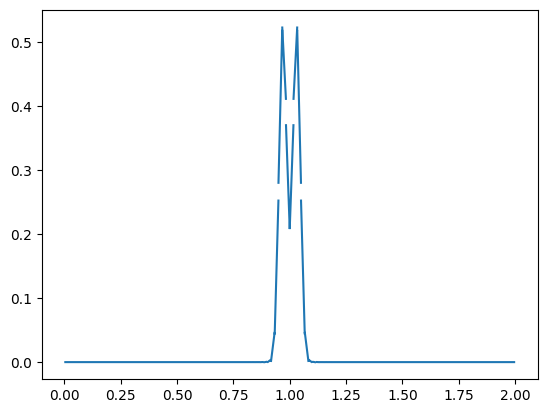

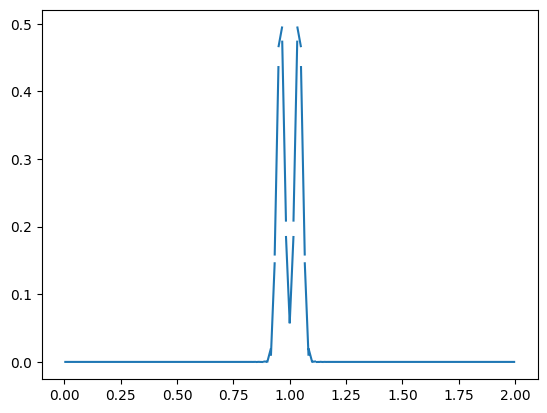

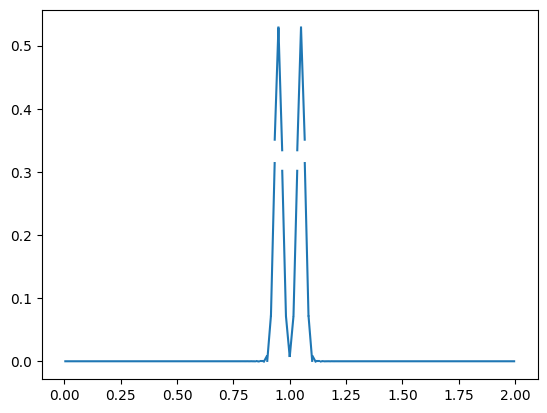

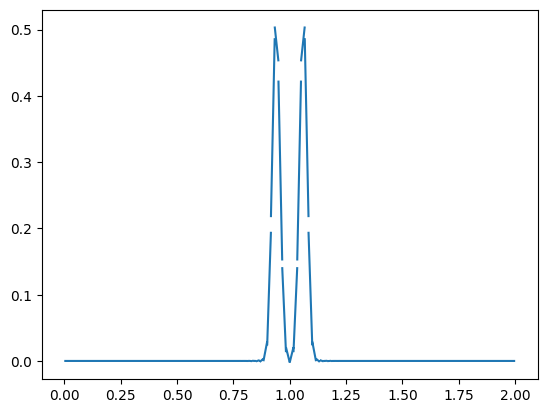

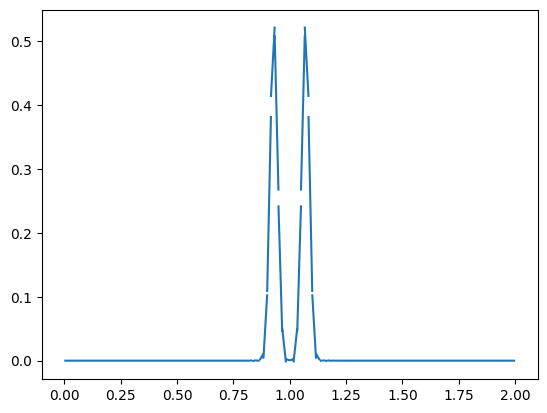

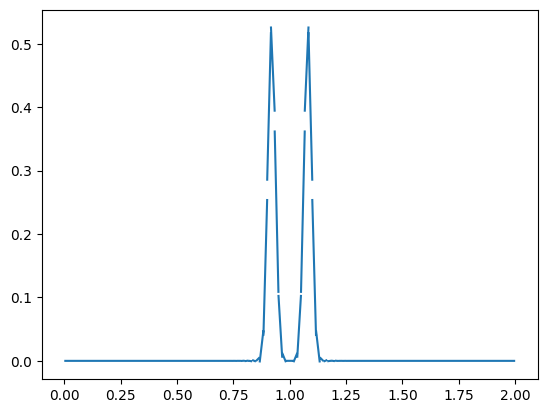

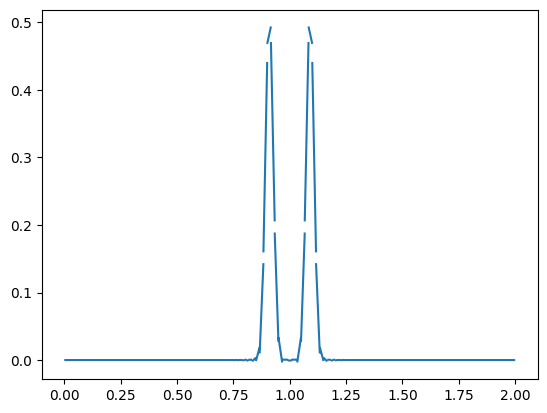

In [4]:
for n in range(1000):
    U.assign(U1)
    solver.solve()
    if n%100 == 0:
      plot(h1)

## Exercises:
* Run the code for another 1000 timesteps and see what happens to the space inbetween the two waves.
* Does reducing the timestep further help? Or increasing the resolution?
* Now examine the function spaces that we chose and the derivatives that appear in our weak form. We have integrated the terms involving a spatial derivative on $h$ by parts, reducing the differentiability requirements on $h$, but we have not taken this into account when chosing our finite element function spaces. Change the definition of $V_u$ so that it is a piecewise quadratic continuous function space and that of $V_h$ so that it is a piecewise linear discontinuous function space (use "DG" instead of "CG"). Rerun the code. What happens?
* Looking at the continuous equations, there is no obvious reason to choose the spaces in this order - why shouldn't $V_u$ be a piecewise linear discontinuous function space and $V_h$ be a piecewise quadratic continuous function space? Make this switch in the code. Does it work? What else do you have to change to make it work?